In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName('ddam_project')
         .config('spark.some.config.option','some-value')
         .getOrCreate()
         )

In [62]:
# read file from hdfs and infer schema
df_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)
df_cleaned.printSchema()

root
 |-- id: long (nullable = true)
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Hotel_Country: string (nullable = true)



In [63]:
# register table 
try:
    df_cleaned.createTempView('cleaned')
except:
    # overwrites if table exists
    spark.catalog.dropTempView('cleaned')
    df_cleaned.createTempView('cleaned')

# Bias computation using the mean

The bias has been computed as:  
the mean of the Reviewer_Score for each Reviewer_Nationality  
MINUS  
the overall global Reviewer_Score mean  
We have considered the bias only for countries with number of reviewers > 100

In [64]:
import pyspark.sql.functions as f

In [65]:
tot_avg = spark.sql("SELECT   COUNT(*) AS N, \
AVG(Reviewer_Score) AS AVG_SCORE, \
STDDEV(Reviewer_Score) AS S \
FROM cleaned \
GROUP BY NULL \
").rdd.collect()[0]['AVG_SCORE']

In [66]:
df_temp = spark.sql("SELECT Reviewer_Nationality,  COUNT(*) AS N, \
AVG(Reviewer_Score) AS AVG_SCORE, \
STDDEV(Reviewer_Score) AS S \
FROM cleaned \
GROUP BY Reviewer_Nationality  \
HAVING N> 100 \
ORDER BY AVG_SCORE DESC \
").withColumn('Tot_Avg', f.lit(tot_avg))
df_temp.show()


+--------------------+------+-----------------+------------------+-----------------+
|Reviewer_Nationality|     N|        AVG_SCORE|                 S|          Tot_Avg|
+--------------------+------+-----------------+------------------+-----------------+
|              Panama|   117|8.788888888888888|1.4026930857177227|8.392897271028017|
|United States of ...| 34887| 8.78780347980614|1.5073551292818983|8.392897271028017|
|         Puerto Rico|   169|  8.7603550295858| 1.588321176248055|8.392897271028017|
|              Israel|  6456|8.694733581164826|1.5103577808400275|8.392897271028017|
| Trinidad and Tobago|   154|8.677922077922076|1.2885238427110572|8.392897271028017|
|         New Zealand|  3195|8.653020344287944|1.3905642252860766|8.392897271028017|
|           Australia| 21412|8.592051186250648| 1.483046772456401|8.392897271028017|
|             Bermuda|   101| 8.57920792079208|1.4278877288977008|8.392897271028017|
|              Canada|  7792|8.547869609856289|1.5202101738245324

In [67]:
df_bias = df_temp.withColumn('Bias', df_temp.AVG_SCORE - df_temp.Tot_Avg)
df_bias.show(100)

+--------------------+------+------------------+------------------+-----------------+--------------------+
|Reviewer_Nationality|     N|         AVG_SCORE|                 S|          Tot_Avg|                Bias|
+--------------------+------+------------------+------------------+-----------------+--------------------+
|              Panama|   117| 8.788888888888888|1.4026930857177227|8.392897271028017| 0.39599161786087045|
|United States of ...| 34887|  8.78780347980614|1.5073551292818983|8.392897271028017| 0.39490620877812255|
|         Puerto Rico|   169|   8.7603550295858| 1.588321176248055|8.392897271028017| 0.36745775855778184|
|              Israel|  6456| 8.694733581164826|1.5103577808400275|8.392897271028017| 0.30183631013680845|
| Trinidad and Tobago|   154| 8.677922077922076|1.2885238427110572|8.392897271028017| 0.28502480689405907|
|         New Zealand|  3195| 8.653020344287944|1.3905642252860766|8.392897271028017| 0.26012307325992623|
|           Australia| 21412| 8.59205

In [70]:
df_bias.write.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_bias_mean.csv", header = True)

## Bias with median

### Method
The median has been computed for each country by 
looking for the median position over of each partition by the Reviewer_Nationality

In [43]:
from pyspark.sql import Window

# setting up the window partitions
grp_window = Window.partitionBy(df_cleaned['Reviewer_Nationality']).orderBy('Reviewer_Score')
grp_count = Window.partitionBy(df_cleaned['Reviewer_Nationality'])
#my_median = f.expr('f.percentRank')

In [44]:
#partititioning the Reviewer_Nationality
df_part = df_cleaned.select('Hotel_Name', 'Reviewer_Nationality', 'Reviewer_Score', 
                  f.row_number().over(grp_window).alias('row'),
                  f.count('Hotel_Name').over(grp_count).alias('N')
                 )

In [45]:
df_part.show(5)
# register table 
try:
    df_part.createTempView('median_temp')
except:
    # overwrites if table exists
    spark.catalog.dropTempView('median_temp')
    df_part.createTempView('median_temp')

+--------------------+--------------------+--------------+---+---+
|          Hotel_Name|Reviewer_Nationality|Reviewer_Score|row|  N|
+--------------------+--------------------+--------------+---+---+
|    H tel Diva Opera|Turks Caicos Islands|           4.2|  1| 14|
|          Hotel 1898|Turks Caicos Islands|           5.0|  2| 14|
|        Hotel Mozart|Turks Caicos Islands|           5.4|  3| 14|
|Hyatt Regency Par...|Turks Caicos Islands|           5.5|  4| 14|
|Au Manoir Saint G...|Turks Caicos Islands|           7.5|  5| 14|
+--------------------+--------------------+--------------+---+---+
only showing top 5 rows



In [46]:
# Computing the median position, splitting the case when the partition count is even/odd
spark.sql(
    'SELECT Hotel_Name, Reviewer_Nationality, Reviewer_Score, row, \
    CASE WHEN(N%2==0) THEN (N/2) \
    ELSE ((N+1)/2) END AS MEDIAN_POS \
    FROM median_temp'
         ).show()

+--------------------+--------------------+--------------+---+----------+
|          Hotel_Name|Reviewer_Nationality|Reviewer_Score|row|MEDIAN_POS|
+--------------------+--------------------+--------------+---+----------+
|    H tel Diva Opera|Turks Caicos Islands|           4.2|  1|       7.0|
|          Hotel 1898|Turks Caicos Islands|           5.0|  2|       7.0|
|        Hotel Mozart|Turks Caicos Islands|           5.4|  3|       7.0|
|Hyatt Regency Par...|Turks Caicos Islands|           5.5|  4|       7.0|
|Au Manoir Saint G...|Turks Caicos Islands|           7.5|  5|       7.0|
|Bcn Urban Hotels ...|Turks Caicos Islands|           7.9|  6|       7.0|
|St Martins Lane A...|Turks Caicos Islands|           7.9|  7|       7.0|
|  Aloft London Excel|Turks Caicos Islands|           8.8|  8|       7.0|
|Thistle Kensingto...|Turks Caicos Islands|           9.6|  9|       7.0|
|Park Grand Paddin...|Turks Caicos Islands|           9.6| 10|       7.0|
|Shangri La Hotel ...|Turks Caicos Isl

In [47]:
# compute the total median
tot_median = df_cleaned.approxQuantile("Reviewer_Score", [0.5], 0.0)[0]
tot_median

8.8

In [48]:
# we then select the median by matching the median_pos and row, 
# add the global median
df_median_temp = (spark.sql(
    'SELECT Reviewer_Nationality, Reviewer_Score AS Median, row, N, \
    CASE WHEN(N%2==0) THEN (N/2) \
    ELSE ((N+1)/2) END AS MEDIAN_POS \
    FROM median_temp'
         ).filter('row=MEDIAN_POS and N>100')
 .orderBy('Reviewer_Score', ascending=False)
 .withColumn('Tot_Median', f.lit(tot_median))
)
df_median_temp.show(10)

+--------------------+------+-----+-----+----------+----------+
|Reviewer_Nationality|Median|  row|    N|MEDIAN_POS|Tot_Median|
+--------------------+------+-----+-----+----------+----------+
|         Puerto Rico|   9.6|   85|  169|      85.0|       8.8|
|          Costa Rica|   9.2|   59|  118|      59.0|       8.8|
|United States of ...|   9.2|17444|34887|   17444.0|       8.8|
|           Australia|   9.2|10706|21412|   10706.0|       8.8|
|              Israel|   9.2| 3228| 6456|    3228.0|       8.8|
|         South Korea|   9.2|  525| 1049|     525.0|       8.8|
|              Canada|   9.2| 3896| 7792|    3896.0|       8.8|
|         New Zealand|   9.2| 1598| 3195|    1598.0|       8.8|
|              Panama|   9.2|   59|  117|      59.0|       8.8|
|              Mexico|   9.2|  288|  576|     288.0|       8.8|
+--------------------+------+-----+-----+----------+----------+
only showing top 10 rows



In [49]:
df_bias_median = df_median_temp.withColumn('Bias_median', df_median_temp.Median - df_median_temp.Tot_Median)
df_bias_median.show(200)

+--------------------+------+------+------+----------+----------+-------------------+
|Reviewer_Nationality|Median|   row|     N|MEDIAN_POS|Tot_Median|        Bias_median|
+--------------------+------+------+------+----------+----------+-------------------+
|         Puerto Rico|   9.6|    85|   169|      85.0|       8.8| 0.7999999999999989|
|              Israel|   9.2|  3228|  6456|    3228.0|       8.8| 0.3999999999999986|
|              Mexico|   9.2|   288|   576|     288.0|       8.8| 0.3999999999999986|
|         South Korea|   9.2|   525|  1049|     525.0|       8.8| 0.3999999999999986|
|United States of ...|   9.2| 17444| 34887|   17444.0|       8.8| 0.3999999999999986|
|              Canada|   9.2|  3896|  7792|    3896.0|       8.8| 0.3999999999999986|
|         New Zealand|   9.2|  1598|  3195|    1598.0|       8.8| 0.3999999999999986|
|          Costa Rica|   9.2|    59|   118|      59.0|       8.8| 0.3999999999999986|
|           Australia|   9.2| 10706| 21412|   10706.0|

In [91]:
df_bias_median.write.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_bias_median.csv", header = True)

# Plots

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

In [57]:
###########################################################
import matplotlib.pyplot as plt
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y label
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

###########################################################


In [59]:
# countries  = ["Puerto Rico", "United States of America", "United Kingdom", "China", "Ireland", "France", "Italy", "Netherlands", "Iran"]
countries  = ["United States of America", "United Kingdom", "China", "France", "Italy", "Netherlands", "Iran"]

scores = []
for i, country in enumerate(countries):
    df_country = (df_cleaned.filter("Reviewer_Nationality = '{}' ".format(country))
                  .select('Hotel_Name', 'Reviewer_Score').toPandas()
                 )
    scores.append(df_country.Reviewer_Score)

/home/student18/env-py3/lib/python3.4/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


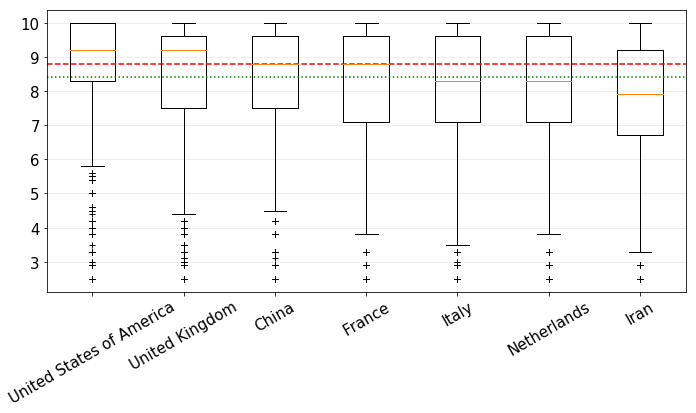

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
bp = plt.boxplot(scores)
ax.set_xticklabels(countries, rotation = 30)

plt.axhline(tot_median, color = 'red', linestyle = "--")
plt.axhline(tot_avg, color = 'green', linestyle = ":")


plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
plt.tight_layout()
plt.savefig('images/nationality_bias.pdf')